In [1]:
%run ../../_setup.py

import numpy as np
from netCDF4 import Dataset
from scipy.interpolate import griddata

import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import string
import gsw


In [2]:
from scipy.interpolate import interp1d
def interp(xp, yp, xi):
    
    xp = np.ma.masked_invalid(xp)
    yp = np.ma.masked_invalid(yp)
    
    mask = xp.mask | yp.mask
        
    f = interp1d(xp[~mask], yp[~mask], bounds_error=False, kind='linear')
    
    return f(xi)


In [3]:
savefig = False

fs_small = 20 # 20
fs_large = 22 # 22
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

In [4]:
# load ctd and gsw data
input_file = os.path.join(datadir, 'ss9802', 'processed', 'ctd', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file, 'r')

# load gem
input_file_gem = os.path.join(datadir, 'ss9802', 'processed', 'ctd', 'ss9802_ctd_gem.nc')
gem = Dataset(input_file_gem, 'r')
# gem.variables.keys()

### Create Dynamic Height contours with the reference level (1494 dbar) considered as the level of 'no-motion'


In [5]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p'][:]):
    pressure_levels[p] = ip

# define reference and interest level 
# p_ref = 1494
p_int = 2

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])

# transect stations
transects = {1: list(reversed(range(2, 10))), 2: list(range(10, 18)), 3: list(reversed(range(18, 27))),
             4: list(range(26, 34)), 5: list(reversed(range(36, 46))), 6: list(range(46, 57)),
             7: list(reversed(range(56, 65))), 8: list(reversed(range(68, 76))), 9: list(range(76, 84)),
             10: list(reversed(range(84, 91))), 11: list([93, 92] + list(range(94, 101)))}

# watermass definitions
watermass = {
    'ML': (26.4, 26.8),
    'SAMW': (26.8, 27.0),
    'AAIW': (27.0, 27.7),
    'UCDW': (27.7, 27.98),
}
density_levels = np.unique([value for value in watermass.values()])

# attributes of variables
attr = {'pt' : ('Potential Temperature', cmo.cm.thermal, (2.25, 12.25), cmo.cm.balance, (-1, 1, 16)), 
        'CT' : ('Conservative Temperature', cmo.cm.thermal, (2, 12), cmo.cm.balance, (-1, 1, 26)), 
        'SA': ('Absolute Salinity', cmo.cm.haline, (34, 35), cmo.cm.delta, (-0.2, 0.2, 26)),
        'sigma0': ('Potential density', cmo.cm.dense, (26.4, 27.7), cmo.cm.curl, (-0.05, 0.05, 16)),
        'gamman': ('Neutral density', cmo.cm.dense, (26.35, 27.95), cmo.cm.diff_r, (-0.05, 0.05, 16))
       }

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Warning: converting a masked element to nan.
  del sys.path[0]


## Anomaly for each transect (interpolated)

In [6]:
Di = np.linspace(np.nanmin(D), np.nanmax(D))
core = (np.nanmin(D) + np.nanmax(D)) / 2
Dgrd, pgrd = np.meshgrid(Di, ctd['p'][:])

In [7]:
keys = list(transects.keys())
keys.insert(4, 4)

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


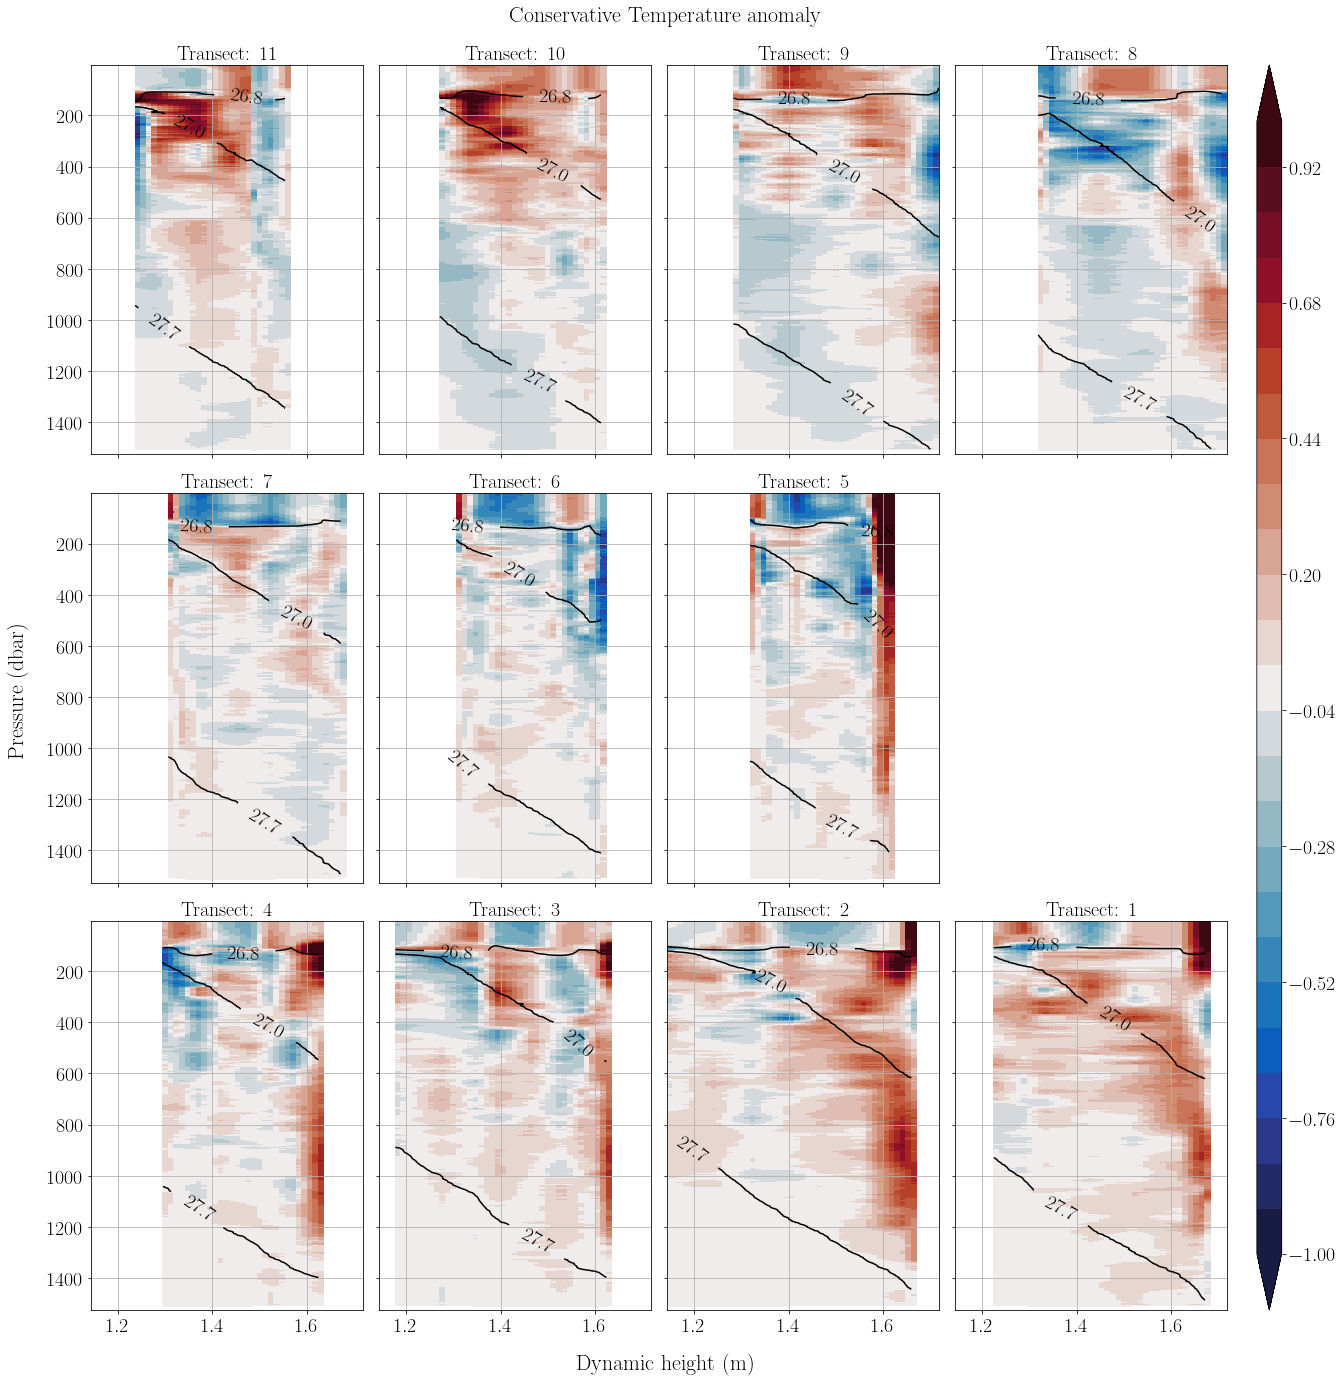

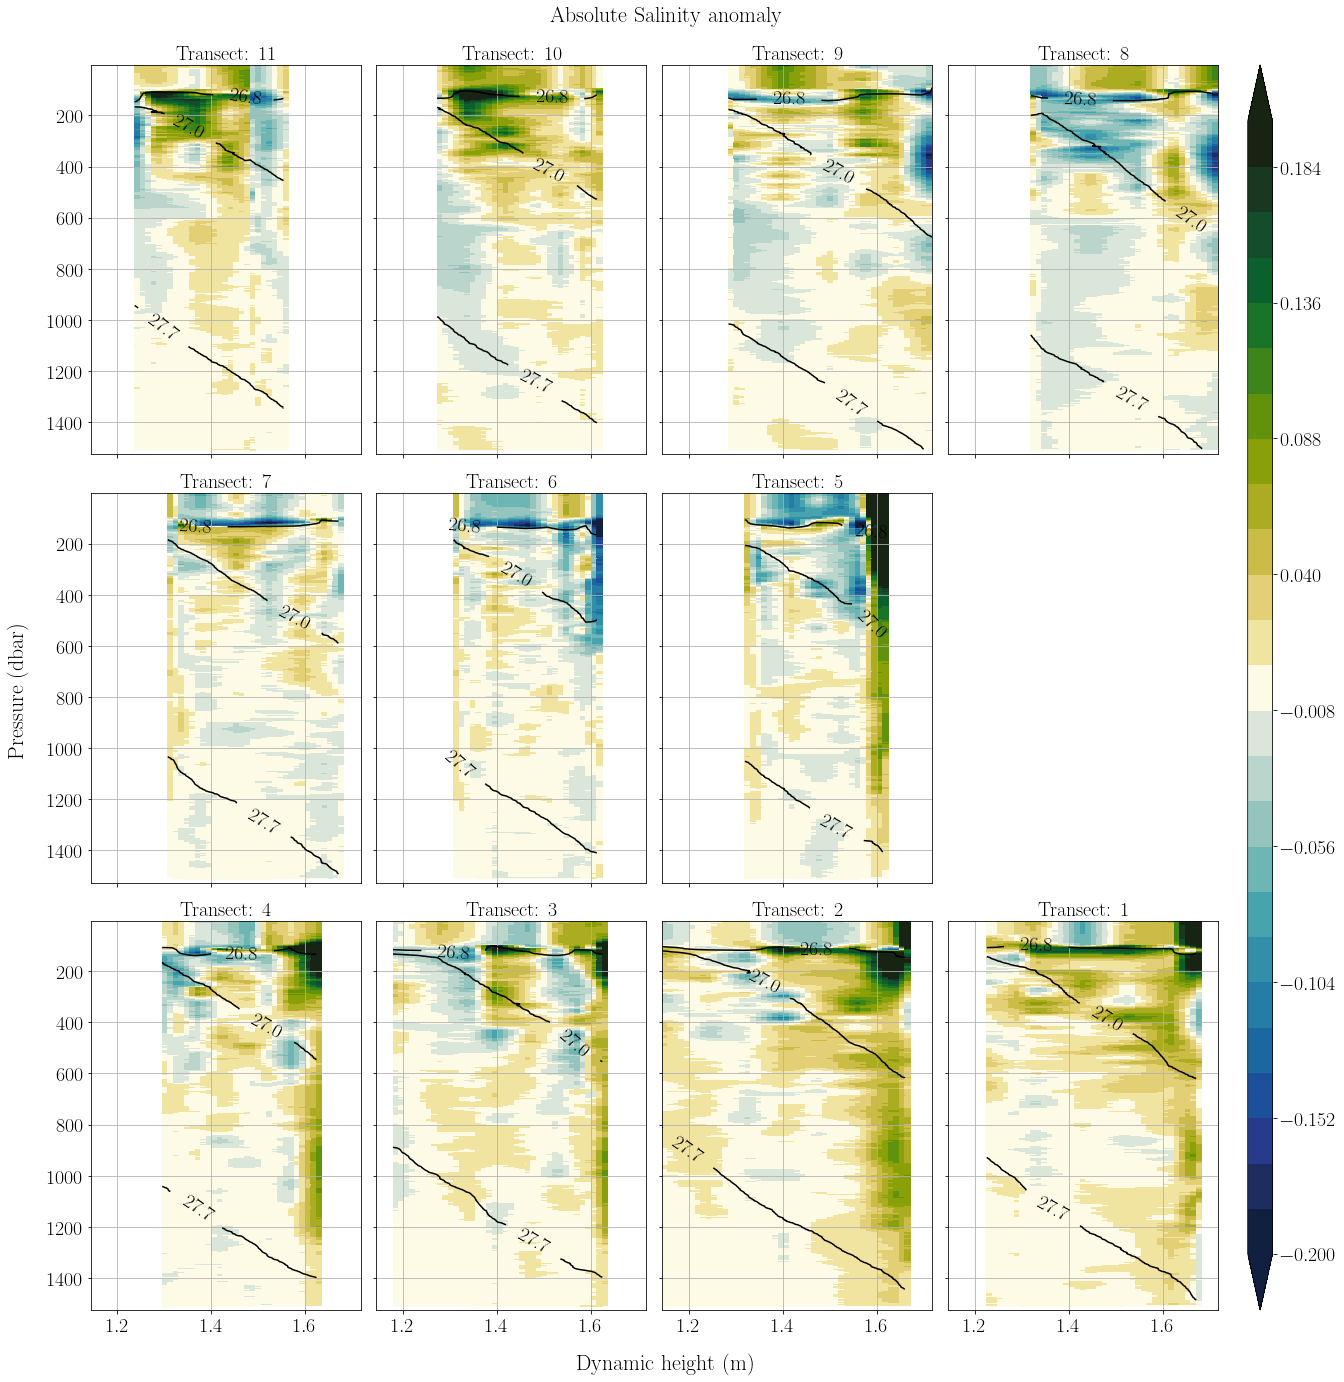

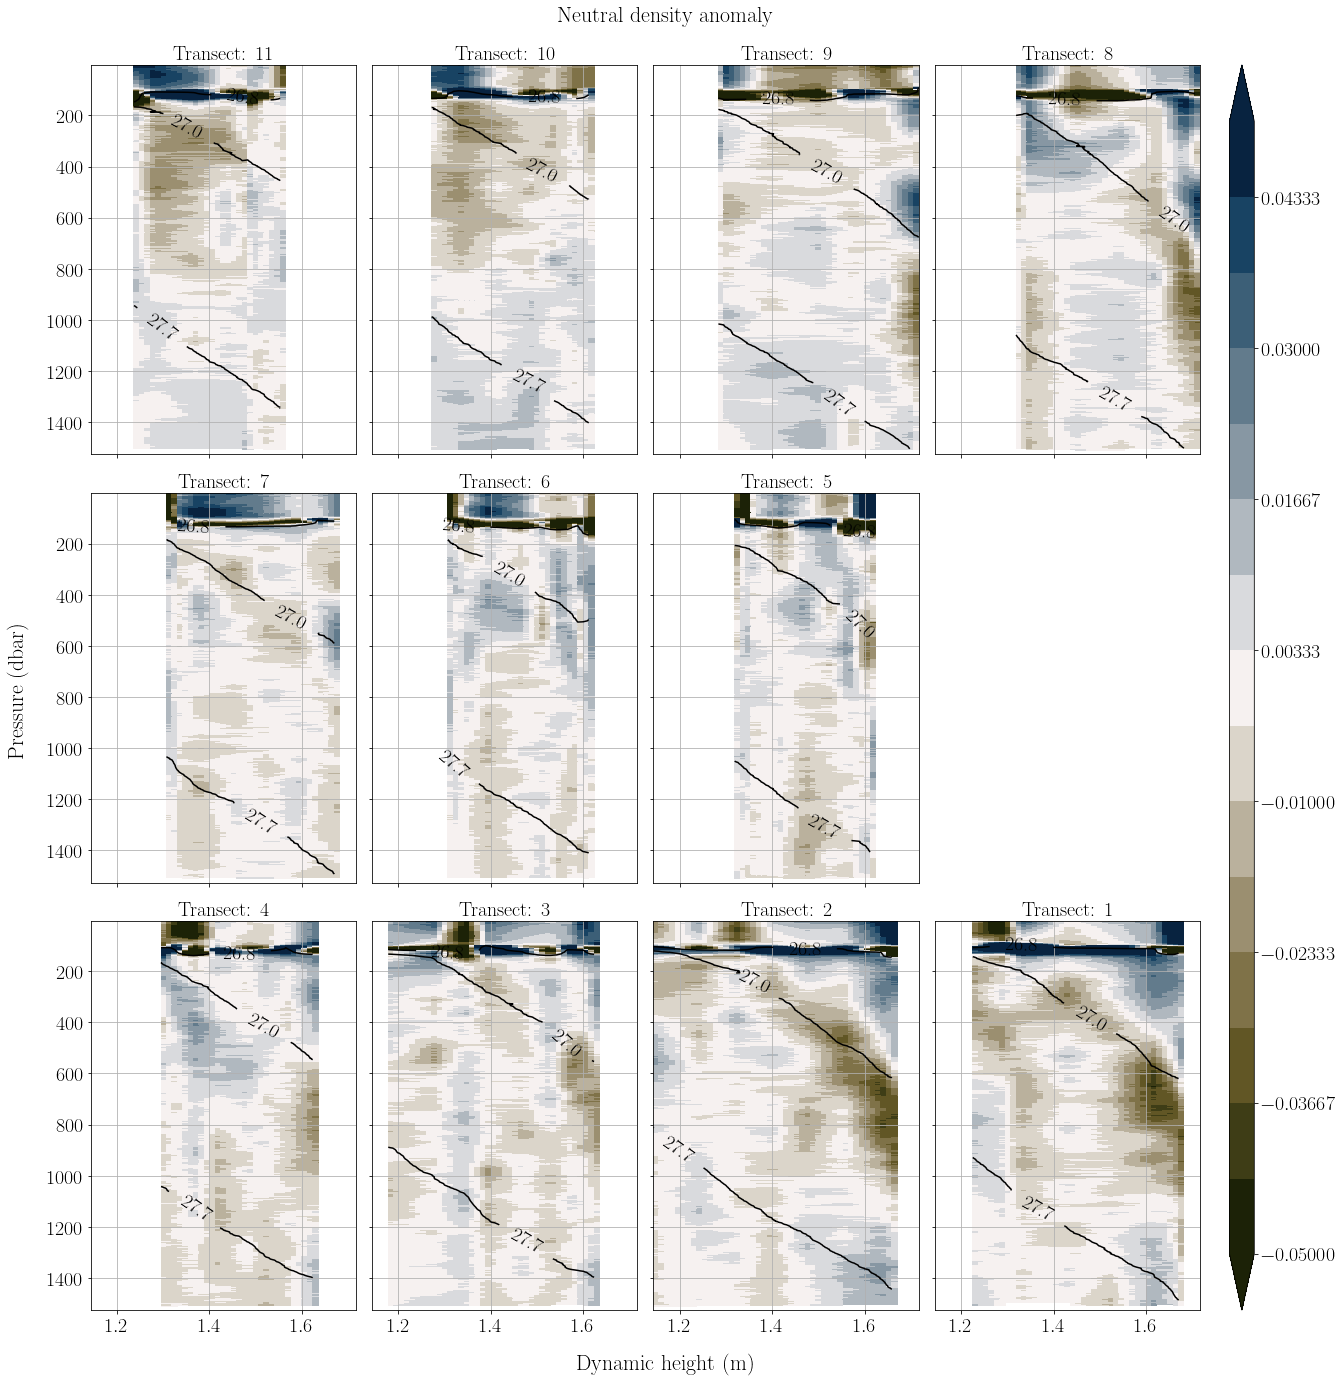

In [8]:
for ivar, var in enumerate(['CT', 'SA', 'gamman']):
    
    anomaly = ctd[var][:] - gem[var][:]
        
    bounds = np.linspace(attr[var][4][0], attr[var][4][1], attr[var][4][2])
    norm = mcolors.BoundaryNorm(bounds, ncolors=attr[var][3].N)

    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True, constrained_layout=True)
    axes[0,0].invert_yaxis()
    for ax, transect in zip(axes.flat, reversed(keys)):
        stations = transects[transect]

        mask = ctd[var][stations].mask | gem[var][stations].mask
        pgrd_ts, Dgrd_ts = np.meshgrid(ctd['p'][:], D[stations])
      
        points = list(zip(Dgrd_ts[~mask].flatten(), pgrd_ts[~mask].flatten()))
        values = anomaly[stations][~mask].flatten()

        # anomaly
        anomaly_interp = griddata(points, values, (Dgrd, pgrd), method='linear')

        # potential and neutral densty surfaces
        gammangrd = griddata(points, ctd['gamman'][stations][~mask].flatten(), (Dgrd, pgrd), method='linear')
#         gammangemgrd = griddata(points, gem['gamman'][stations][~mask].flatten(), (Dgrd, pgrd), method='linear')

        pcol = ax.pcolormesh(Dgrd, pgrd, anomaly_interp, norm=norm, cmap=attr[var][3])

        cont = ax.contour(Dgrd, pgrd, gammangrd, density_levels, colors='k')
#         cont2 = ax.contour(Dgrd, pgrd, gammangemgrd, colors='k', linestyles='--')

        ax.clabel(cont, inline=1, fontsize=fs_small, fmt='%.1f', inline_spacing=10)
        ax.set_title('Transect: %s' % transect, fontsize=fs_small)
        
        ax.grid('on')

    fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50, extend='both')
    fig.delaxes(axes.flat[-5])

    # Set common labels
    fig.text(0.48, 1.02, r'%s anomaly' %(attr[var][0]), ha='center', va='center', fontsize=fs_large)
    fig.text(0.48, -0.02, 'Dynamic height (m)', ha='center', va='center', fontsize=fs_large)
    fig.text(-0.02, 0.5, r'Pressure (dbar)', ha='center', va='center', rotation='vertical', fontsize=fs_large)

#     if savefig:
#         fignumber = '04-%s_' % (ivar + 1)
#         figname = {'CT': 'conservative-temperature-anomaly', 'SA': 'absolute-salinity-anomaly', 
#                     'gamman': 'neutral-density-anomaly'}
#         extensions = ['.png', '.pdf', '.eps']
#         for extension in extensions:
#             fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber + figname[var] + extension), 
#                         transparent=True, bbox_inches='tight', pad_inches=1)

## Taylor series of anomaly on pressure and neutral density surfaces

The conservative temperature anomaly on pressure levels between the measurements and the GEM field can be expressed in a Taylor series of the anomaly on neutral density levels (pure warming/ cooling) minus a contribution that consists of the heaving of the isopycnals (pure heaving) $h'$ times the vertical temperature gradient from the GEM field. In this way, water mass transformations can be distinguished from heaving of the isopycnals. Below, the taylor series for conservative temperature is used as an example, but the same holds for absolute salinity.

First, we linear interpolate the conservative temperature field (real and GEM field) from a pressure coordinate system onto a depth ($z$) coordinate system and calculate the vertical gradient of the conservative temperature GEM field,

$$ \Theta(p), \Theta^{GEM}(p) \rightarrow \Theta(z), \Theta^{GEM}(z) $$

$$ \frac{\partial\Theta^{GEM}(z)}{\partial z} $$

Next, we do a similar transformation to a neutral density coordinate system ($\gamma_n$) and we derive the depth of the isopycnals from a transformation of the $\gamma_n$-field,

$$ \Theta(p), \Theta^{GEM}(p) \rightarrow \Theta(\gamma_n), \Theta^{GEM}(\gamma_n) $$

$$ \gamma_n(p), \gamma_n^{GEM}(p), z(p) \rightarrow h(\gamma_n), h^{GEM}(\gamma_n) $$


Then, the Taylor series is described as,
$$\Theta'\left.\right\rvert_{z} = \Theta'\left.\right\rvert_{n} - \left.h' \frac{\partial\Theta}{\partial z}\right\rvert_{n}$$

where,

$$\Theta'\left.\right\rvert_{n} = \Theta(\gamma_n) - \Theta^{GEM}(\gamma_n)$$

$$h'\left.\right\rvert_{n} = h(\gamma_n) - h^{GEM}(\gamma_n)$$.

In order to compare the term on the lhs with the terms on the rhs, a transformation to a mid point $z_m$ between isopycnals is necessary, 

$$ \Theta(z), \Theta^{GEM}(z) \rightarrow \Theta(z_m), \Theta^{GEM}(z_m) $$

$$ \left.\frac{\partial\Theta^{GEM}(z)}{\partial z}\right\rvert_{n} \rightarrow \frac{\partial\Theta^{GEM}}{\partial z} (z_m)$$

such that,

$$\Theta'\left.\right\rvert_{z} = \Theta(z_m) - \Theta^{GEM}(z_m)$$

The mid points on the $z$ coordinate system are defined as

$$ z_m = \frac{h(\gamma_n) + h^{GEM}(\gamma_n)}{2} $$

In [9]:
var = 'CT'

# transformation 1: from p to z
z = np.ma.masked_invalid(ctd['z'])
zi = np.linspace(z.max(), z.min(), ctd['p'].size)
zgrd = np.broadcast_to(zi, ctd['z'].shape)

CT_z = np.ma.masked_all(ctd[var].shape)
# dCTdz_z, dCTdz_gem_z = CT_z.copy(), CT_z.copy()
CT_gem_z, gamman_z, gamman_gem_z = CT_z.copy(), CT_z.copy(), CT_z.copy()
for i in range(len(ctd['station'])):
    CT_z[i,] = interp(ctd['z'][i,], ctd[var][i,], zi)
    CT_gem_z[i,] = interp(ctd['z'][i,], gem[var][i,], zi) if i != 34 else np.nan * np.ones(zi.shape)
    
    gamman_z[i,] = interp(ctd['z'][i,], ctd['gamman'][i,], zi)
    gamman_gem_z[i,] = interp(ctd['z'][i,], gem['gamman'][i,], zi) if i != 34 else np.nan * np.ones(zi.shape)
    
dCTdz_z = np.gradient(CT_z)[1] / np.gradient(zgrd)[1]
dCTdz_gem_z = np.gradient(CT_gem_z)[1] / np.gradient(zgrd)[1]

CT_prime_z = CT_z - CT_gem_z

# transformation 2: from z to gamman
gn = np.ma.masked_invalid(ctd['gamman'])
gni = np.linspace(gn.min(), gn.max(), ctd['p'].size)

CT_gn, CT_gem_gn = np.ma.masked_all(ctd[var].shape), np.ma.masked_all(ctd[var].shape)
SA_gn, SA_gem_gn = CT_gn.copy(), CT_gn.copy()
h_gn, h_gem_gn = CT_gn.copy(), CT_gn.copy()
for i in range(len(ctd['station'])):
    CT_gn[i,] = interp(ctd['gamman'][i,], ctd['CT'][i,], gni)
    CT_gem_gn[i,] = interp(ctd['gamman'][i,], gem['CT'][i,], gni) if i != 34 else np.nan * np.ones(zi.shape)

    SA_gn[i,] = interp(ctd['gamman'][i,], ctd['SA'][i,], gni)
    SA_gem_gn[i,] = interp(ctd['gamman'][i,], gem['SA'][i,], gni) if i != 34 else np.nan * np.ones(ctd['p'].shape)
    
    h_gn[i,] = interp(ctd['gamman'][i,], ctd['z'][i,], gni)
    h_gem_gn[i,] = interp(gem['gamman'][i,], ctd['z'][i], gni) if i != 34 else np.nan * np.ones(zi.shape)

CT_prime_gn = CT_gn - CT_gem_gn
SA_prime_gn = SA_gn - SA_gem_gn
h_prime_gn = h_gn - h_gem_gn
    
# transformation 3: from z to zm
zm = (h_gn + h_gem_gn) / 2

CT_zm = np.ma.masked_all(ctd[var].shape)
CT_gem_zm = CT_zm.copy()
dCTdz_zm, dCTdz_gem_zm = CT_zm.copy(), CT_zm.copy()
for i in range(len(ctd['station'])):
    CT_zm[i,] = interp(zi, CT_z[i,], zm[i,].data)
    CT_gem_zm[i,] = interp(zi, CT_gem_z[i,], zm[i,].data) if i != 34 else np.nan * np.ones(zi.shape)
    
    dCTdz_zm[i,] = interp(zi, dCTdz_z[i,], zm[i,].data) if i != 34 else np.nan * np.ones(zi.shape)
    dCTdz_gem_zm[i,] = interp(zi, dCTdz_gem_z[i,], zm[i,].data) if i != 34 else np.nan * np.ones(zi.shape)

CT_prime_zm = CT_zm - CT_gem_zm
dCTdz_prime_zm = dCTdz_zm - dCTdz_gem_zm
# dCTdz_zm = np.gradient(CT_gem_zm)[1] / np.gradient(zm)[1]



In [10]:
# var = 'CT'

# # transformation 2: from constant pressure p to gamman
# gn = np.ma.masked_invalid(ctd['gamman'])
# gni = np.linspace(gn.min(), gn.max(), ctd['p'].size)

# CT_gn, SA_gn = np.ma.masked_all(ctd['CT'].shape), np.ma.masked_all(ctd['SA'].shape)
# CT_gem_gn, SA_gem_gn = CT_gn.copy(), SA_gn.copy()
# z_gn, z_gem_gn = CT_gn.copy(), CT_gn.copy()
# for i in range(len(ctd['station'])):

#     CT_gn[i,] = interp(ctd['gamman'][i,], ctd['CT'][i,], gni)
#     CT_gem_gn[i,] = interp(ctd['gamman'][i,], gem['CT'][i,], gni) if i != 34 else np.nan * np.ones(ctd['p'].shape)
    
#     SA_gn[i,] = interp(ctd['gamman'][i,], ctd['SA'][i,], gni)
#     SA_gem_gn[i,] = interp(ctd['gamman'][i,], gem['SA'][i,], gni) if i != 34 else np.nan * np.ones(ctd['p'].shape)
    
#     z_gn[i,] = interp(ctd['gamman'][i,], ctd['z'][i,], gni)
#     z_gem_gn[i,] = interp(gem['gamman'][i,], ctd['z'][i], gni) if i != 34 else np.nan * np.ones(ctd['p'].shape)

# CT_prime_gn = CT_gn - CT_gem_gn
# SA_prime_gn = SA_gn - SA_gem_gn
# h_prime_gn = z_gn - z_gem_gn
# zm = (z_gn + z_gem_gn) / 2

# # transformation
# CT_zm = np.ma.masked_all(ctd[var].shape)
# CT_gem_zm = CT_zm.copy()
# dCTdp_zm, dCTdp_gem_zm = CT_zm.copy(), CT_zm.copy()
# for i in range(len(ctd['station'])):

#     CT_zm[i,] = interp(ctd['z'][i,], ctd[var][i,], zm[i,].data)
#     CT_gem_zm[i,] = interp(ctd['z'][i,], gem[var][i,], zm[i,].data) if i != 34 else np.nan * np.ones(ctd['p'].shape)

#     dCTdp = np.gradient(ctd[var][i,]) / np.gradient(ctd['p'][:])
#     dCTdp_gem = np.gradient(gem[var][i,]) / np.gradient(ctd['p'])
    
#     dCTdp_zm[i,] = interp(ctd['z'][i,], dCTdp, zm[i,].data)
#     dCTdp_gem_zm[i,] = interp(ctd['z'][i,], dCTdp_gem, zm[i,].data) if i != 34 else np.nan * np.ones(ctd['p'].shape)
    
#     del dCTdp, dCTdp_gem
    
# CT_prime_zm = CT_zm - CT_gem_zm

### Anomaly of Conservative Temperature in vertical coordinate system (z)

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if sys.path[0] == '':


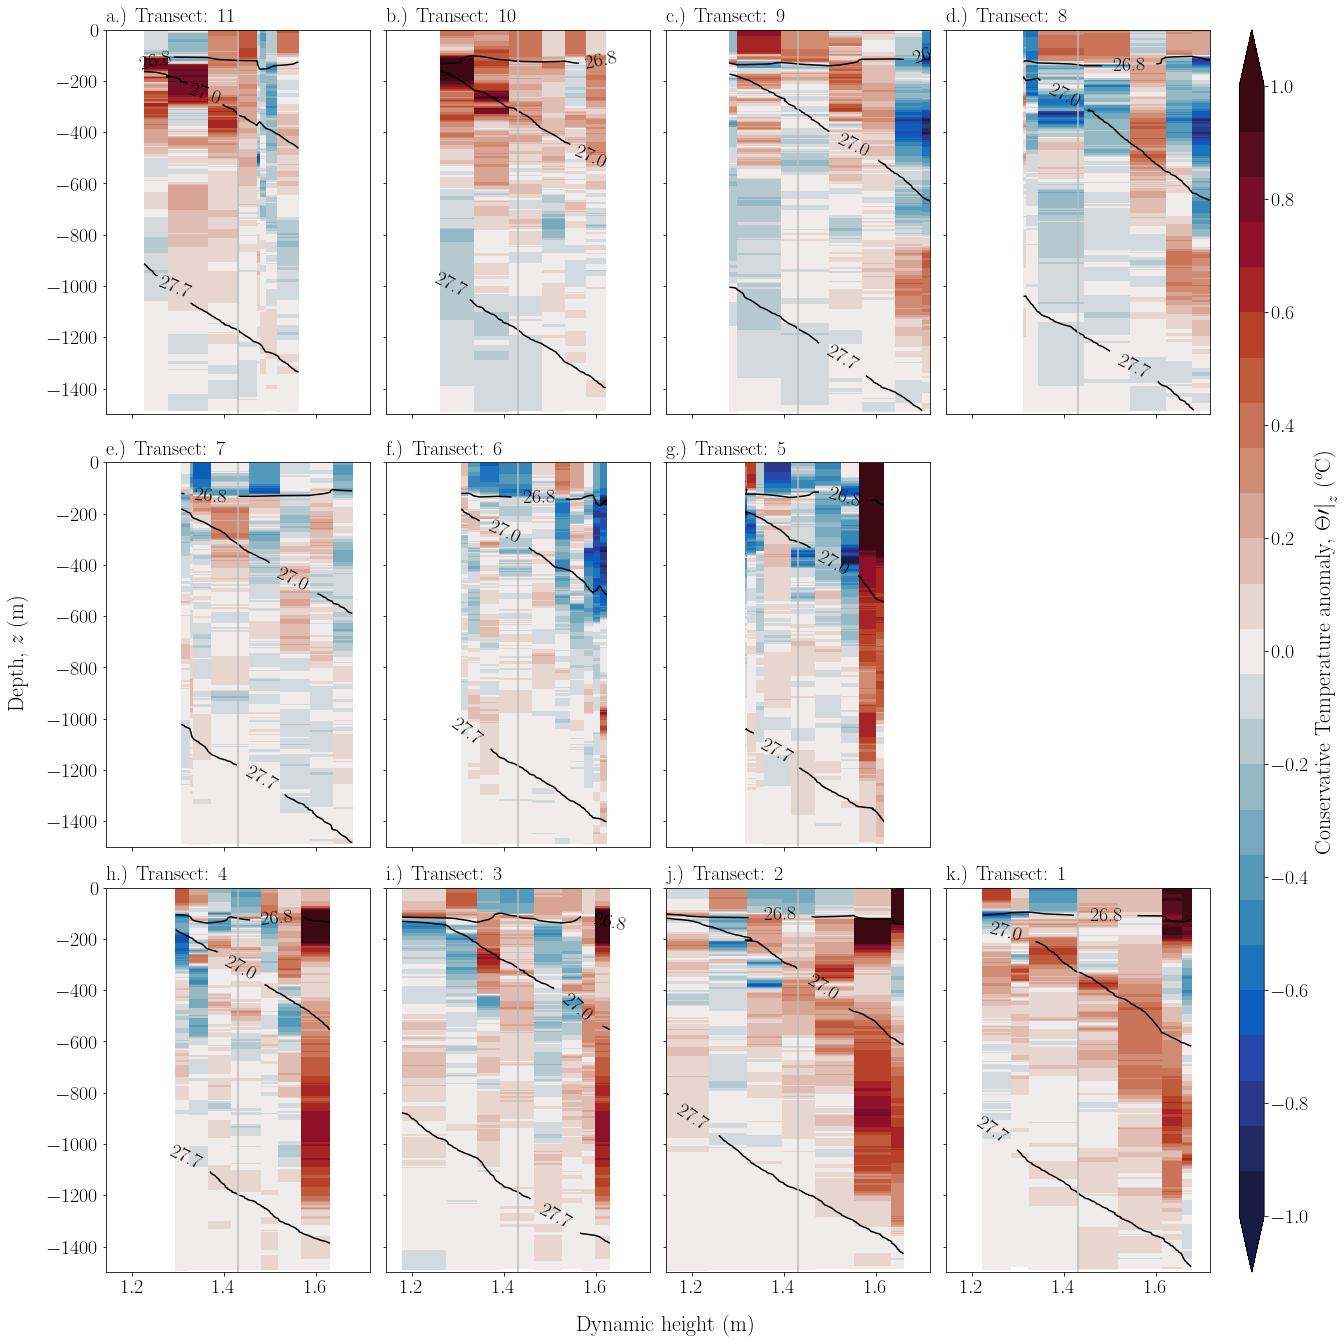

In [11]:
# odds = [0, 1, 8, 9, 10, 11, 26, 44, 45, 46, 74, 75, 76, 77, 100]

bounds = np.linspace(attr[var][4][0], attr[var][4][1], attr[var][4][2])
norm = mcolors.BoundaryNorm(bounds, ncolors=attr[var][3].N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True, constrained_layout=True)

for ax, transect in zip(axes.flat, reversed(keys)):
    stations = transects[transect]
#     stations = [x for x in stations if x not in odds]
    
    pcol = ax.pcolormesh(D[stations], zi, CT_prime_z[stations].T, norm=norm, cmap=attr[var][3])
    
    mask = gamman_z[stations].mask
    zz, DD = np.meshgrid(zi, D[stations])
    points = list(zip(DD[~mask].flatten(), zz[~mask].flatten()))
    values = gamman_z[stations][~mask].flatten()
    gamman_z_grd = griddata(points, values, (DD, zz), method='linear')

    cont = ax.contour(DD, zz, gamman_z_grd, density_levels, colors='k')
    ax.clabel(cont, inline=1, fontsize=fs_small, fmt='%.1f', inline_spacing=10)

#     ax.set_title('Transect: %s' % transect, fontsize=fs_small)
    ax.set_ylim([-1500, 0])

    # panel numbering
    ax.text(0, 1.02, string.ascii_lowercase[len(transects)-transect] + '.) ' + 'Transect: %s' % transect, 
            transform=ax.transAxes, size=fs_small, weight='bold')

    # grid line
    #     ax.grid(which='major', axis='both')
#     ax.grid('on')
    ax.axvline(core, color='#bbb')
    
cbar = fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50, extend='both', ticks=np.linspace(-1, 1, 11))
cbar.ax.set_ylabel(r'%s anomaly, $\left.\Theta\prime\right|_{z}$ ($^o$C)' %(attr[var][0]), 
                   fontsize=fs_large)
fig.delaxes(axes.flat[-5])

# Set common labels
# fig.text(0.48, 1.02, r'%s anomaly, $\left.\Theta\prime\right|_{z}$ ($^o$C)' %(attr[var][0]), ha='center', va='center', fontsize=fs_large)
fig.text(0.48, -0.02, 'Dynamic height (m)', ha='center', va='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Depth, $z$ (m)', ha='center', va='center', rotation='vertical', fontsize=fs_large)

if savefig:
    fignumber = {'CT': '03_', 'SA': '03-2_', 'gamman': '03-3_'}
    figname = {'CT': 'conservative-temperature-anomaly-z', 'SA': 'absolute-salinity-anomaly-z', 
                'gamman': 'neutral-density-anomaly-z'}
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber[var] + figname[var] + extension), 
                    transparent=True, bbox_inches='tight', pad_inches=1)

### Anomaly of Conservative Temperature on neutral density surfaces (first term Taylor expansion)

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  del sys.path[0]


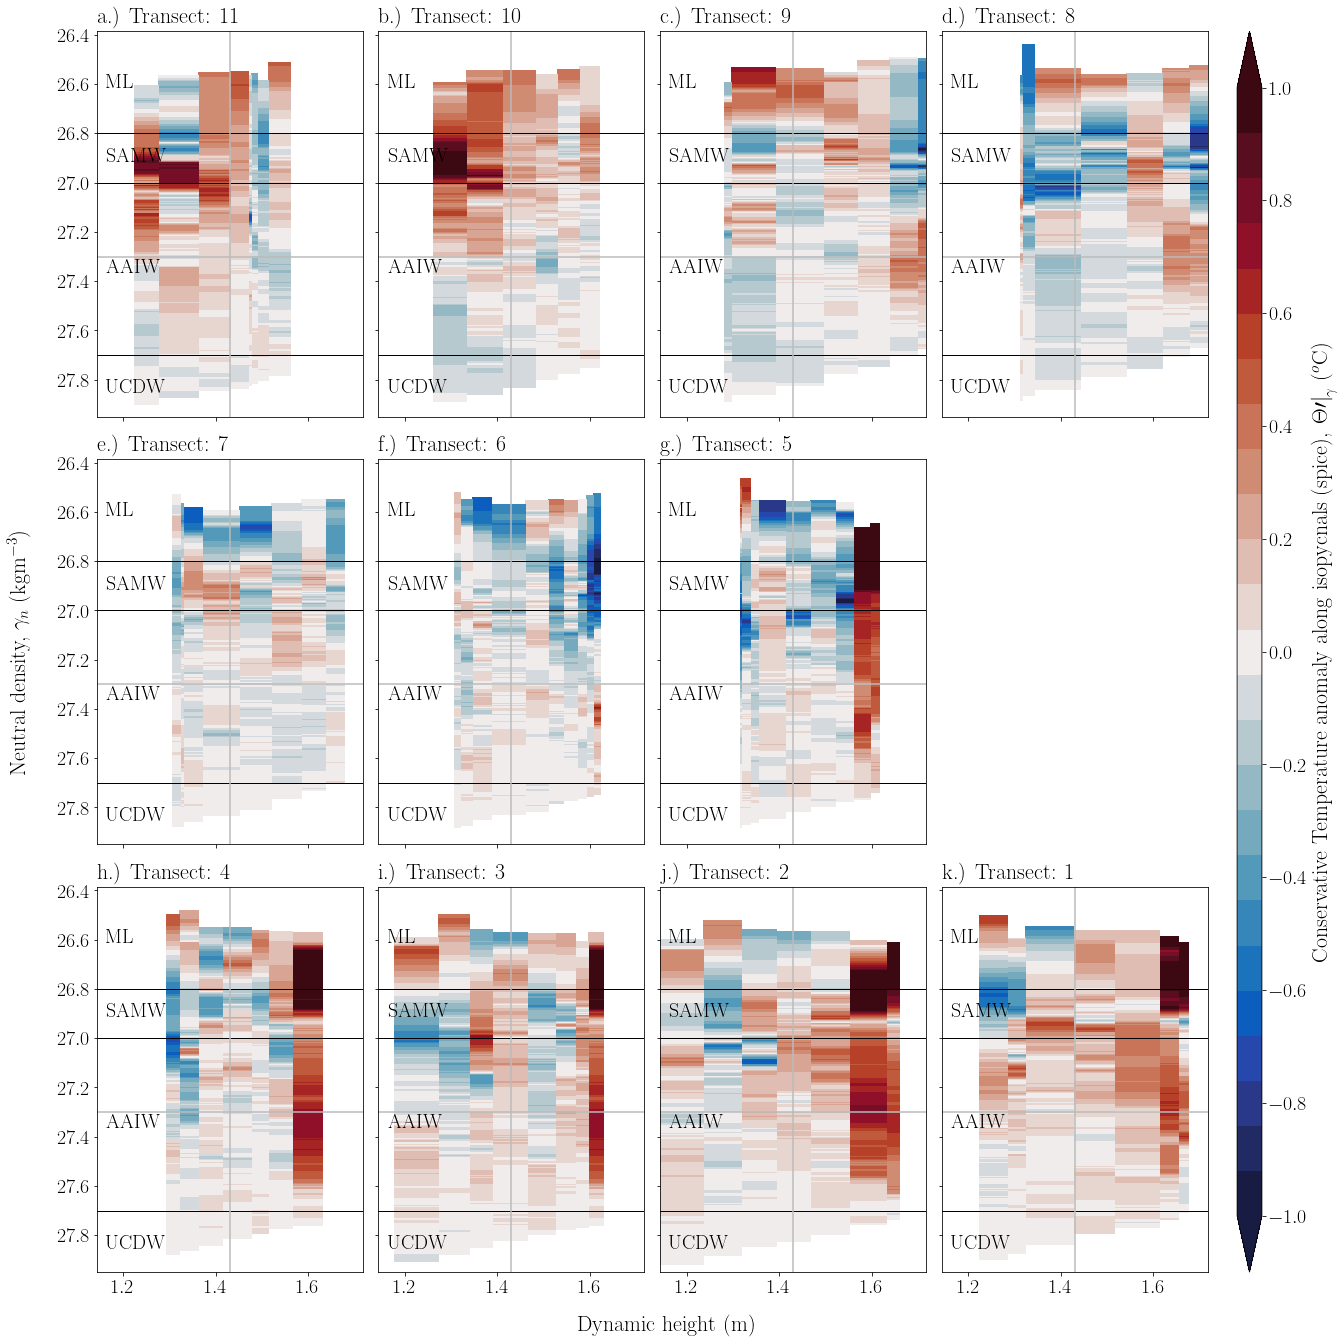

In [12]:
bounds = np.linspace(attr[var][4][0], attr[var][4][1], attr[var][4][2])
norm = mcolors.BoundaryNorm(bounds, ncolors=attr[var][3].N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True, constrained_layout=True)

axes[0,0].invert_yaxis()

for ax, transect in zip(axes.flat, reversed(keys)):

    stations = transects[transect]
    
    pcol = ax.pcolormesh(D[stations], gni, CT_prime_gn[stations].T, 
                         norm=norm, cmap=attr[var][3])
    for wm in watermass:
        if wm is not 'UCDW':
            ax.axhline(watermass[wm][1], linewidth=1, color='k')
        ax.text(np.nanmin(D[2:]) + .02, np.sum(watermass[wm])/2 + .03, wm, va='bottom', fontsize=fs_small)
        
#     ax.set_title('Transect: %s' % transect, fontsize=fs_small)
    
    # panel numbering
    ax.text(0, 1.02, string.ascii_lowercase[len(transects)-transect] + '.) ' + 'Transect: %s' % transect, 
            transform=ax.transAxes, size=fs_large, weight='bold')

    # grid line
    #     ax.grid(which='major', axis='both')
    ax.axvline(core, color='#bbb')
    ax.axhline(27.3, color='#bbb')

fig.delaxes(axes.flat[-5])

# Set common labels
# fig.text(0.48, 1.02, r'%s anomaly (pure warming), $\left.\Theta\prime\right|_{\gamma_n}$ ($^o$C)' %(attr[var][0]), ha='center', va='center', fontsize=fs_large)
fig.text(0.48, -0.02, 'Dynamic height (m)', ha='center', va='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Neutral density, $\gamma_n$ (kgm$^{-3}$)', ha='center', va='center', rotation='vertical', fontsize=fs_large)

cbar = fig.colorbar(pcol, ax=fig.get_axes(), aspect=50, extend='both', ticks=np.linspace(-1, 1, 11))
cbar.ax.set_ylabel(r'%s anomaly along isopycnals (spice), $\left.\Theta\prime\right|_{\gamma}$ ($^o$C)' %(attr[var][0]), 
                   fontsize=fs_large)

if savefig:
    fignumber = {'CT': '04_', 'SA': '04-2_', 'gamman': '04-3_'}
    figname = {'CT': 'conservative-temperature-anomaly-spice', 'SA': 'absolute-salinity-anomaly-spice', 
                'gamman': 'neutral-density-anomaly-spice'}
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber[var] + figname[var] + extension), 
                    transparent=True, bbox_inches='tight', pad_inches=1)

Along a neutral surface, by definition,

$$ \alpha\left.\Theta'\right\rvert_{n} = \beta \left.S_A'\right\rvert_{n} $$


In [13]:
# thermal expansion coefficient and saline contraction coefficient
alpha = gsw.alpha(ctd['SA'][:], ctd['CT'][:], ctd['p'][:])
beta = gsw.beta(ctd['SA'][:], ctd['CT'][:], ctd['p'][:])

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


Text(-0.02, 0.5, 'Neutral density, $\\gamma_n$ (kgm$^{-3}$)')

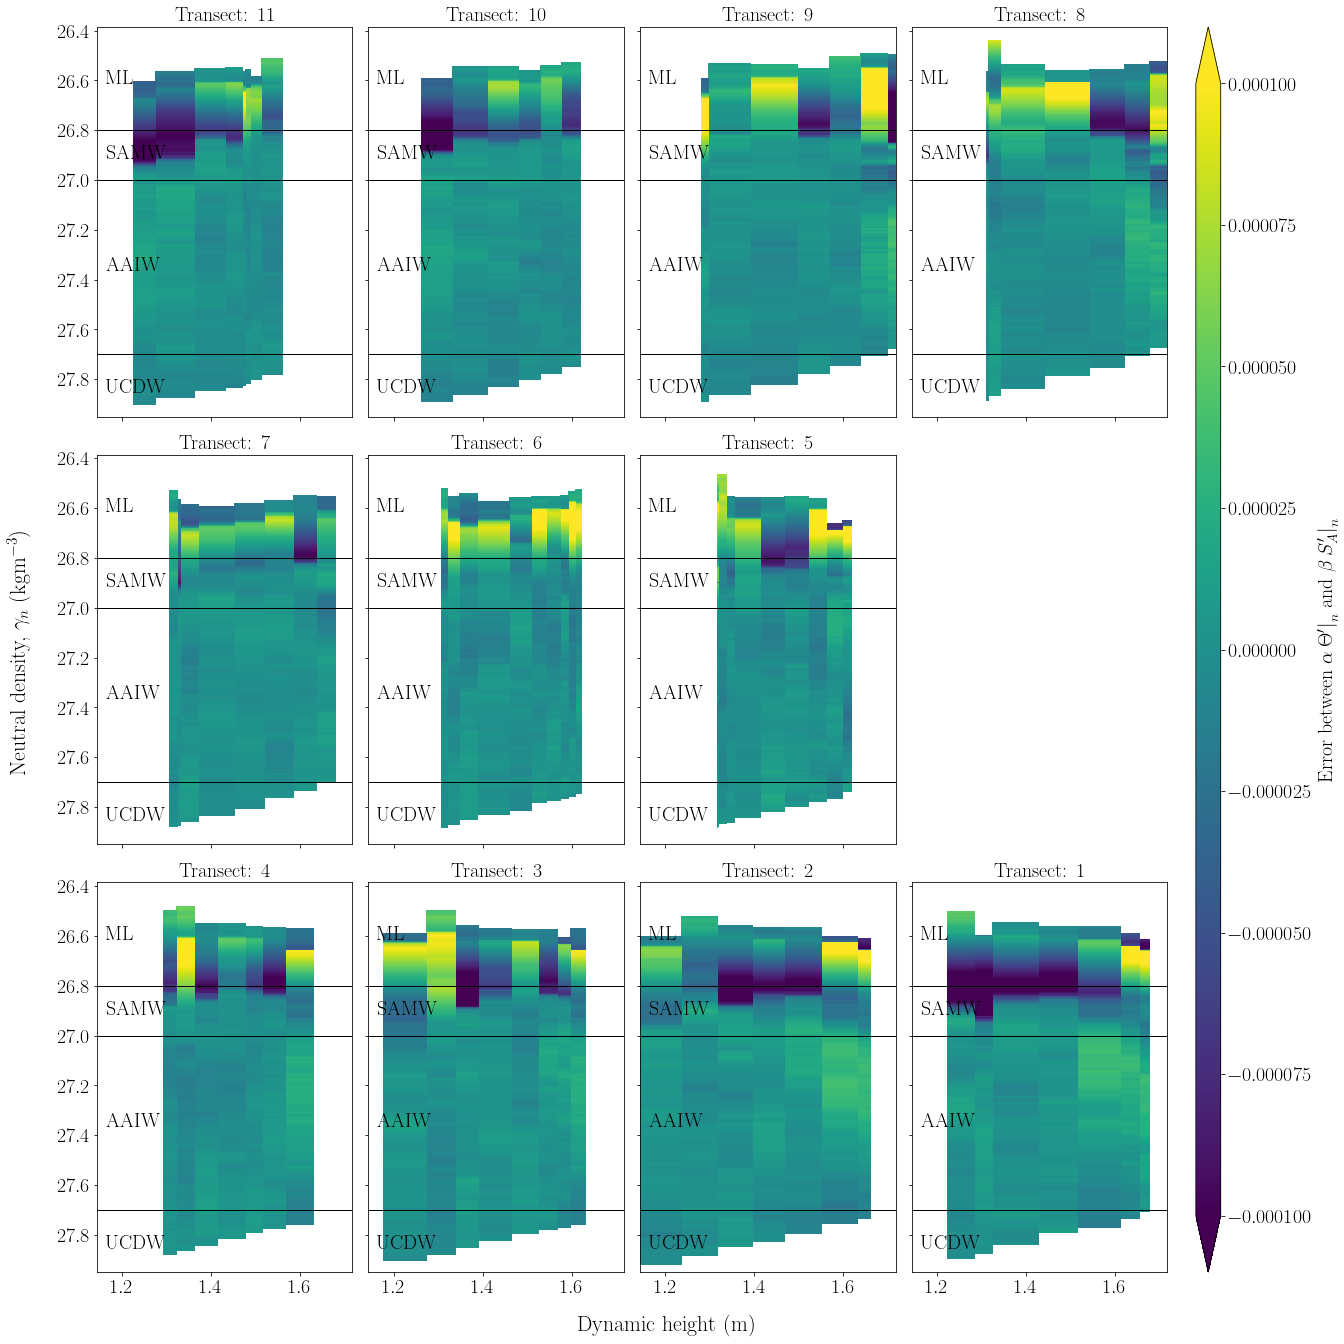

In [14]:
vmin, vmax= -1e-4, 1e-4

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True, constrained_layout=True)

axes[0,0].invert_yaxis()

for ax, transect in zip(axes.flat, reversed(keys)):
    stations = transects[transect]
    
    pcol = ax.pcolormesh(D[stations], gni, (alpha[stations] * CT_prime_gn[stations] - beta[stations] * SA_prime_gn[stations]).T,
                        vmin=vmin, vmax=vmax)
    for wm in watermass:
        if wm is not 'UCDW':
            ax.axhline(watermass[wm][1], linewidth=1, color='k')
        ax.text(np.nanmin(D[2:]) + .02, np.sum(watermass[wm])/2 + .03, wm, va='bottom', fontsize=fs_small)
        
    ax.set_title('Transect: %s' % transect, fontsize=fs_small)

cbar = fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50, extend='both')
cbar.ax.set_ylabel(r"Error between $\alpha\left.\Theta'\right |_{n}$ and $\beta \left.S_A'\right |_{n}$", 
                   fontsize=fs_small)
fig.delaxes(axes.flat[-5])

# Set common labels
# fig.text(0.48, 1.02, r'%s anomaly (pure warming), $\left.\Theta\prime\right|_{\gamma_n}$ ($^o$C)' %(attr[var][0]), ha='center', va='center', fontsize=fs_large)
fig.text(0.48, -0.02, 'Dynamic height (m)', ha='center', va='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Neutral density, $\gamma_n$ (kgm$^{-3}$)', ha='center', va='center', rotation='vertical', fontsize=fs_large)


### Heaving of neutral density surfaces (second term Taylor expansion)

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  # This is added back by InteractiveShellApp.init_path()


Text(-0.02, 0.5, 'Neutral density, $\\gamma_n$ (kgm$^{-3}$)')

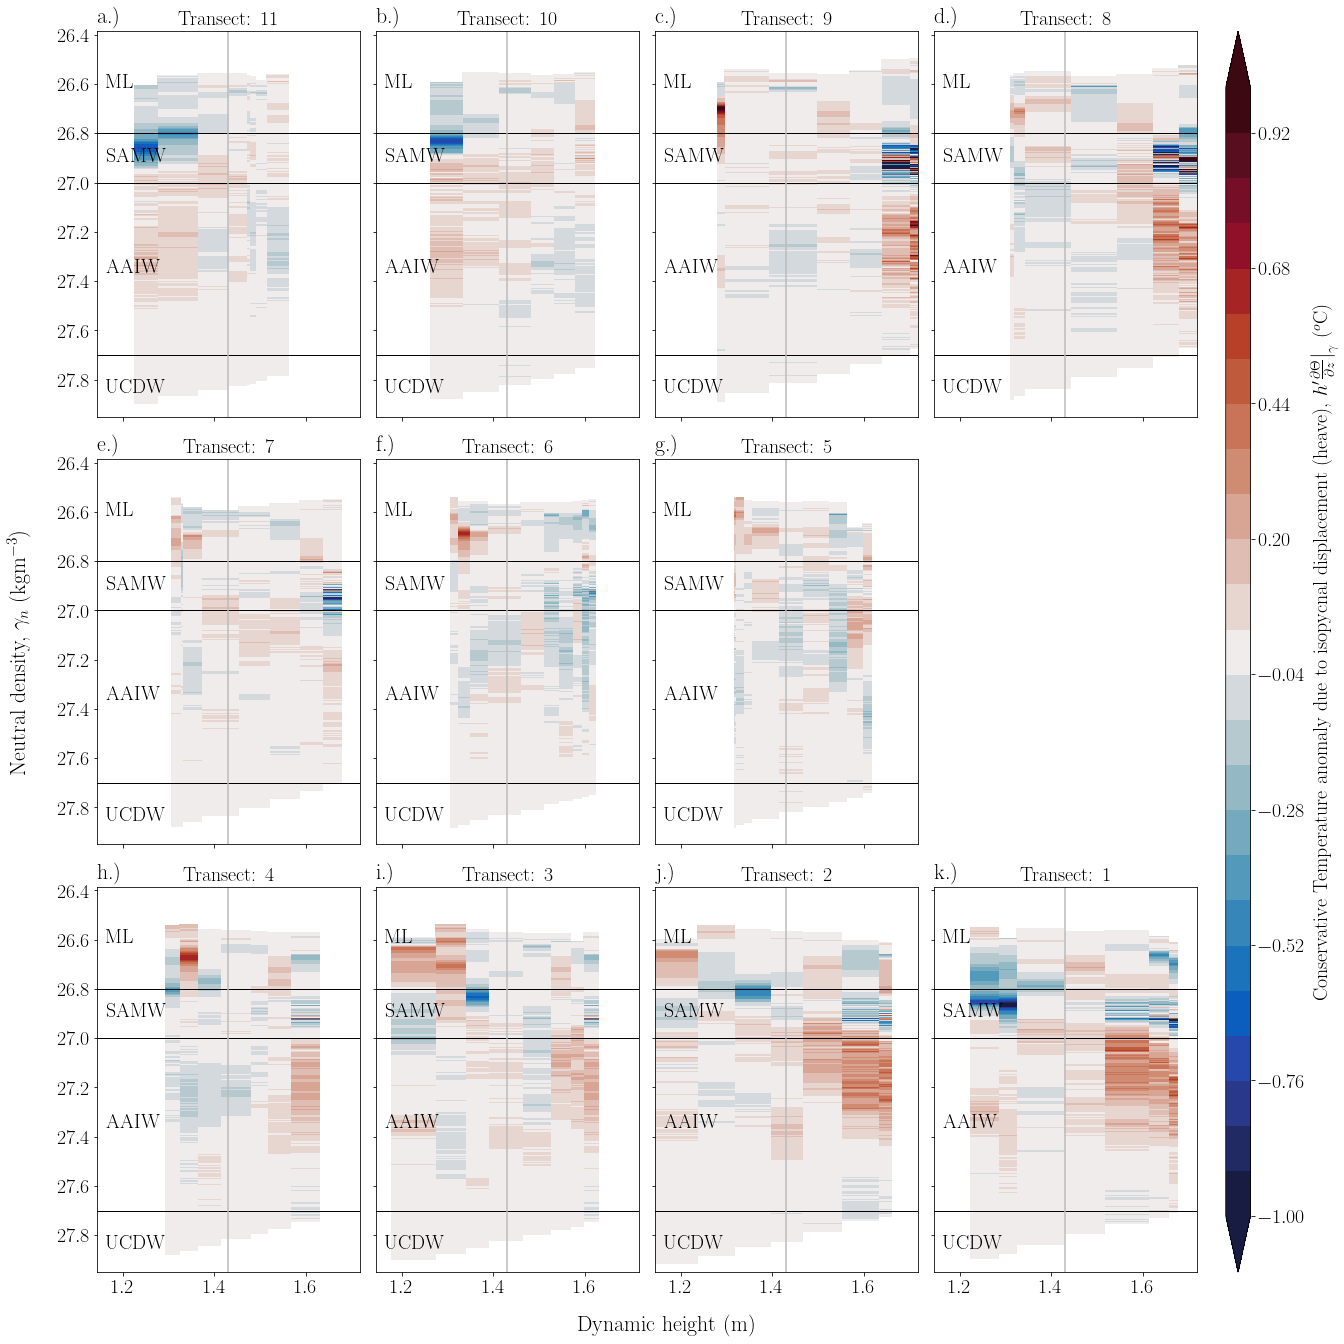

In [15]:
bounds = np.linspace(attr[var][4][0], attr[var][4][1], attr[var][4][2])
norm = mcolors.BoundaryNorm(bounds, ncolors=attr[var][3].N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True, constrained_layout=True)

axes[0,0].invert_yaxis()
for ax, transect in zip(axes.flat, reversed(keys)):
    stations = transects[transect]
    
    pcol = ax.pcolormesh(D[stations], gni, (- h_prime_gn[stations] * dCTdz_gem_zm[stations]).T, 
                         norm=norm, cmap=attr[var][3])
#     pcol = ax.pcolormesh(D[stations], gni, (- h_prime_gn[stations] * 0.5 * (dCTdz_zm[stations] + dCTdz_gem_zm[stations])).T, 
#                          norm=norm, cmap=attr[var][3])
#     pcol = ax.pcolormesh(D[stations], gni, 0.5 * (h_prime_gn[stations] * (dCTdp_zm[stations] + dCTdp_gem_zm[stations])).T, 
#                          norm=norm, cmap=attr[var][3])
    
    for wm in watermass:
        if wm is not 'UCDW':
            ax.axhline(watermass[wm][1], linewidth=1, color='k')
        ax.text(np.nanmin(D[2:]) + .02, np.sum(watermass[wm])/2 + .03, wm, va='bottom', fontsize=fs_small)
        
    ax.set_title('Transect: %s' % transect, fontsize=fs_small)
    
    # panel numbering
    ax.text(0, 1.02, string.ascii_lowercase[len(transects)-transect] + '.)', transform=ax.transAxes, size=fs_large, weight='bold')

    # grid line
    #     ax.grid(which='major', axis='both')
    ax.axvline(core, color='#bbb')

cbar = fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50, extend='both')
cbar.ax.set_ylabel(r'%s anomaly due to isopycnal displacement (heave), $\left.h^\prime\frac{\partial\Theta}{\partial z}\right|_{\gamma}$ ($^o$C)' %(attr[var][0]), 
                   fontsize=fs_small)

fig.delaxes(axes.flat[-5])


# Set common labels
# fig.text(0.48, 1.02, r'%s anomaly (pure heaving), $\left.h\prime\frac{\partial\Theta}{\partial z}\right|_{\gamma_n}$ ($^o$C)' %(attr[var][0]), ha='center', va='center', fontsize=fs_large)
fig.text(0.48, -0.02, 'Dynamic height (m)', ha='center', va='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Neutral density, $\gamma_n$ (kgm$^{-3}$)', ha='center', va='center', rotation='vertical', fontsize=fs_large)

# if savefig:
#     fignumber = {'CT': '05_', 'SA': '05-2_', 'gamman': '05-3_'}
#     figname = {'CT': 'conservative-temperature-anomaly-heave', 'SA': 'absolute-salinity-anomaly-heave', 
#                 'gamman': 'neutral-density-anomaly-heave'}
#     extensions = ['.png', '.pdf', '.eps']
#     for extension in extensions:
#         fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber[var] + figname[var] + extension), 
#                     transparent=True, bbox_inches='tight', pad_inches=1)

### Difference between LHS and RHS of the Taylor series

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Text(-0.02, 0.5, 'Neutral density, $\\gamma_n$ (kgm$^{-3}$)')

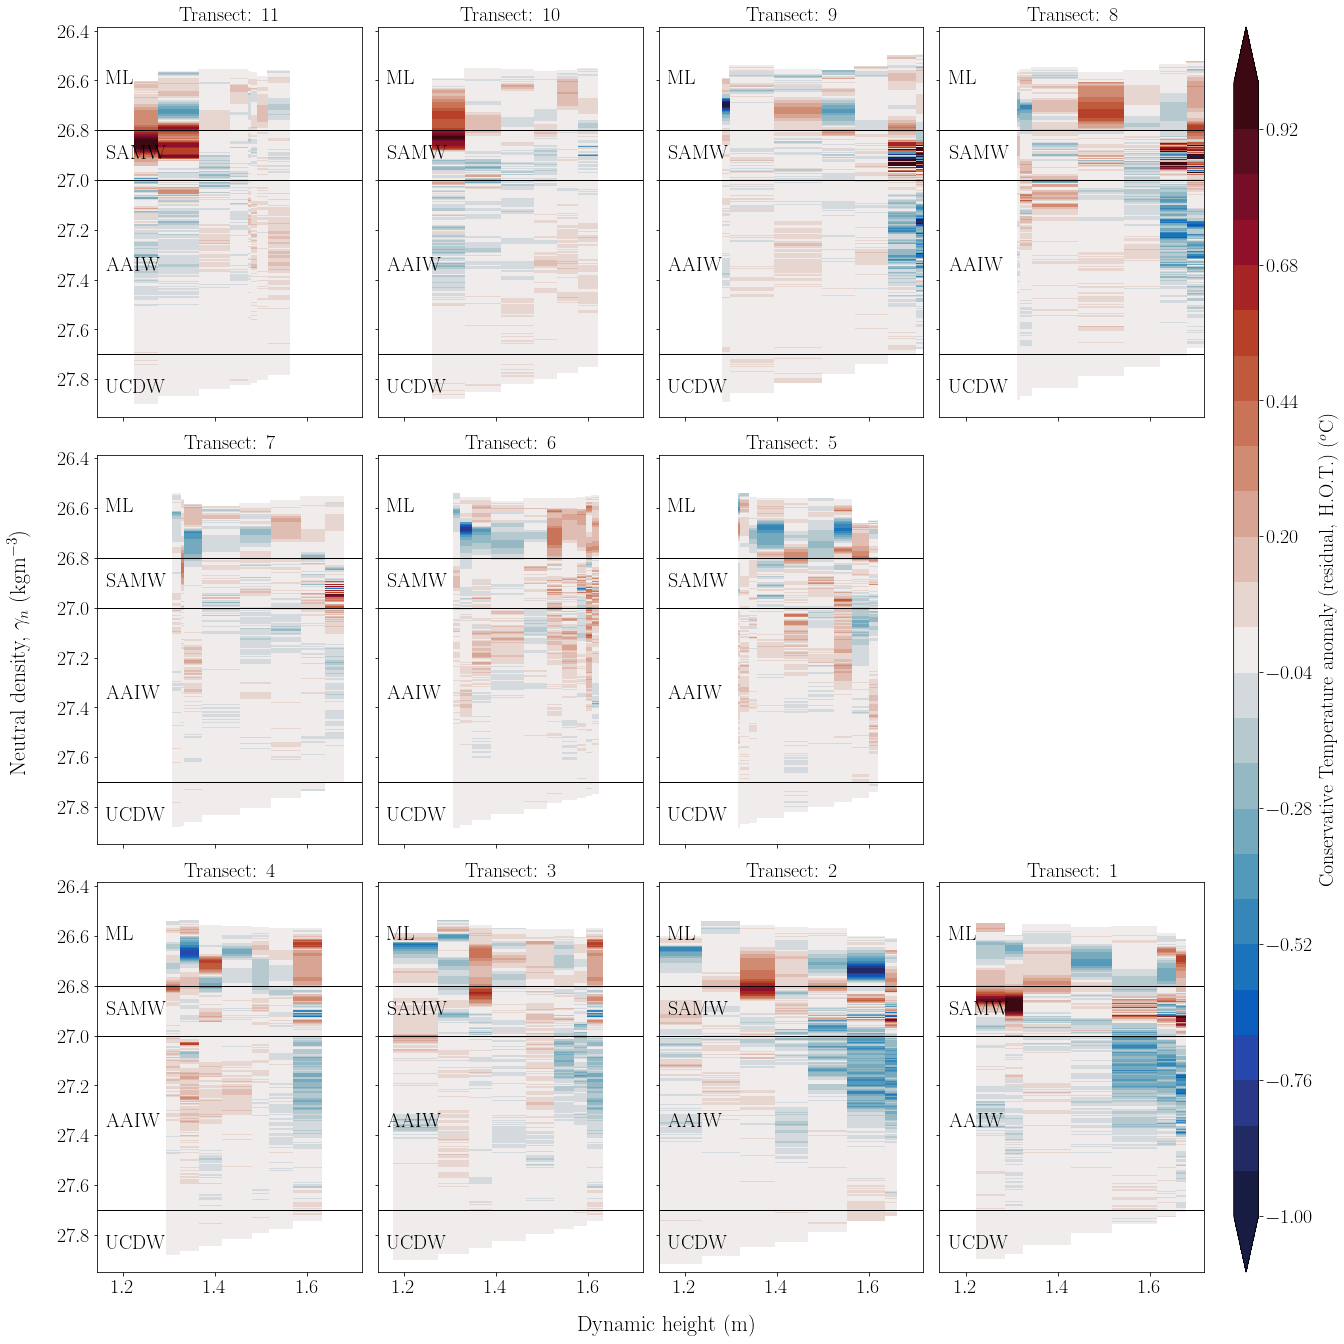

In [16]:
bounds = np.linspace(attr[var][4][0], attr[var][4][1], attr[var][4][2])
norm = mcolors.BoundaryNorm(bounds, ncolors=attr[var][3].N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True, constrained_layout=True)
axes[0,0].invert_yaxis()

for ax, transect in zip(axes.flat, reversed(keys)):
    stations = transects[transect]
    
    lhs = CT_prime_zm[stations]
#     rhs = CT_prime_gn[stations] - (h_prime_gn[stations] * 0.5 * (dCTdz_zm[stations] + dCTdz_gem_zm[stations]))
    rhs = CT_prime_gn[stations] - (h_prime_gn[stations] * dCTdz_gem_zm[stations])
#     rhs = CT_prime_gn[stations] - (0.5 * h_prime_gn[stations] * (dCTdz_zm[stations] + dCTdz_gem_zm[stations]))

    pcol = ax.pcolormesh(D[stations], gni, 
                         (lhs - rhs).T,
                         norm=norm, cmap=attr[var][3])

    for wm in watermass:
        if wm is not 'UCDW':
            ax.axhline(watermass[wm][1], linewidth=1, color='k')
        ax.text(np.nanmin(D[2:]) + .02, np.sum(watermass[wm])/2 + .03, wm, va='bottom', fontsize=fs_small)

    ax.set_title('Transect: %s' % transect, fontsize=fs_small)

cbar = fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50, extend='both')
cbar.ax.set_ylabel(r'%s anomaly (residual, H.O.T.) ($^o$C)' %(attr[var][0]), 
                   fontsize=fs_small)
fig.delaxes(axes.flat[-5])

# Set common labels
# fig.text(0.48, 1.02, r'%s anomaly (residual), H.O.T. ($^o$C)' %(attr[var][0]), ha='center', va='center', fontsize=fs_large)
fig.text(0.48, -0.02, 'Dynamic height (m)', ha='center', va='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Neutral density, $\gamma_n$ (kgm$^{-3}$)', ha='center', va='center', rotation='vertical', fontsize=fs_large)

# if savefig:
#     fignumber = '04_'
#     figname = {'CT': 'conservative-temperature-anomaly-residual', 'SA': 'absolute-salinity-anomaly-residual', 
#                 'gamman': 'neutral-density-anomaly-residual'}
#     extensions = ['.png', '.pdf', '.eps']
#     for extension in extensions:
#         fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber + figname[var] + extension), 
#                     transparent=True, bbox_inches='tight', pad_inches=1)

### Height difference of neutral density surfaces

/home/janjaapmeijer/miniconda3/envs/ocean3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


Text(-0.02, 0.5, 'Neutral density, $\\gamma_n$ (kgm$^{-3}$)')

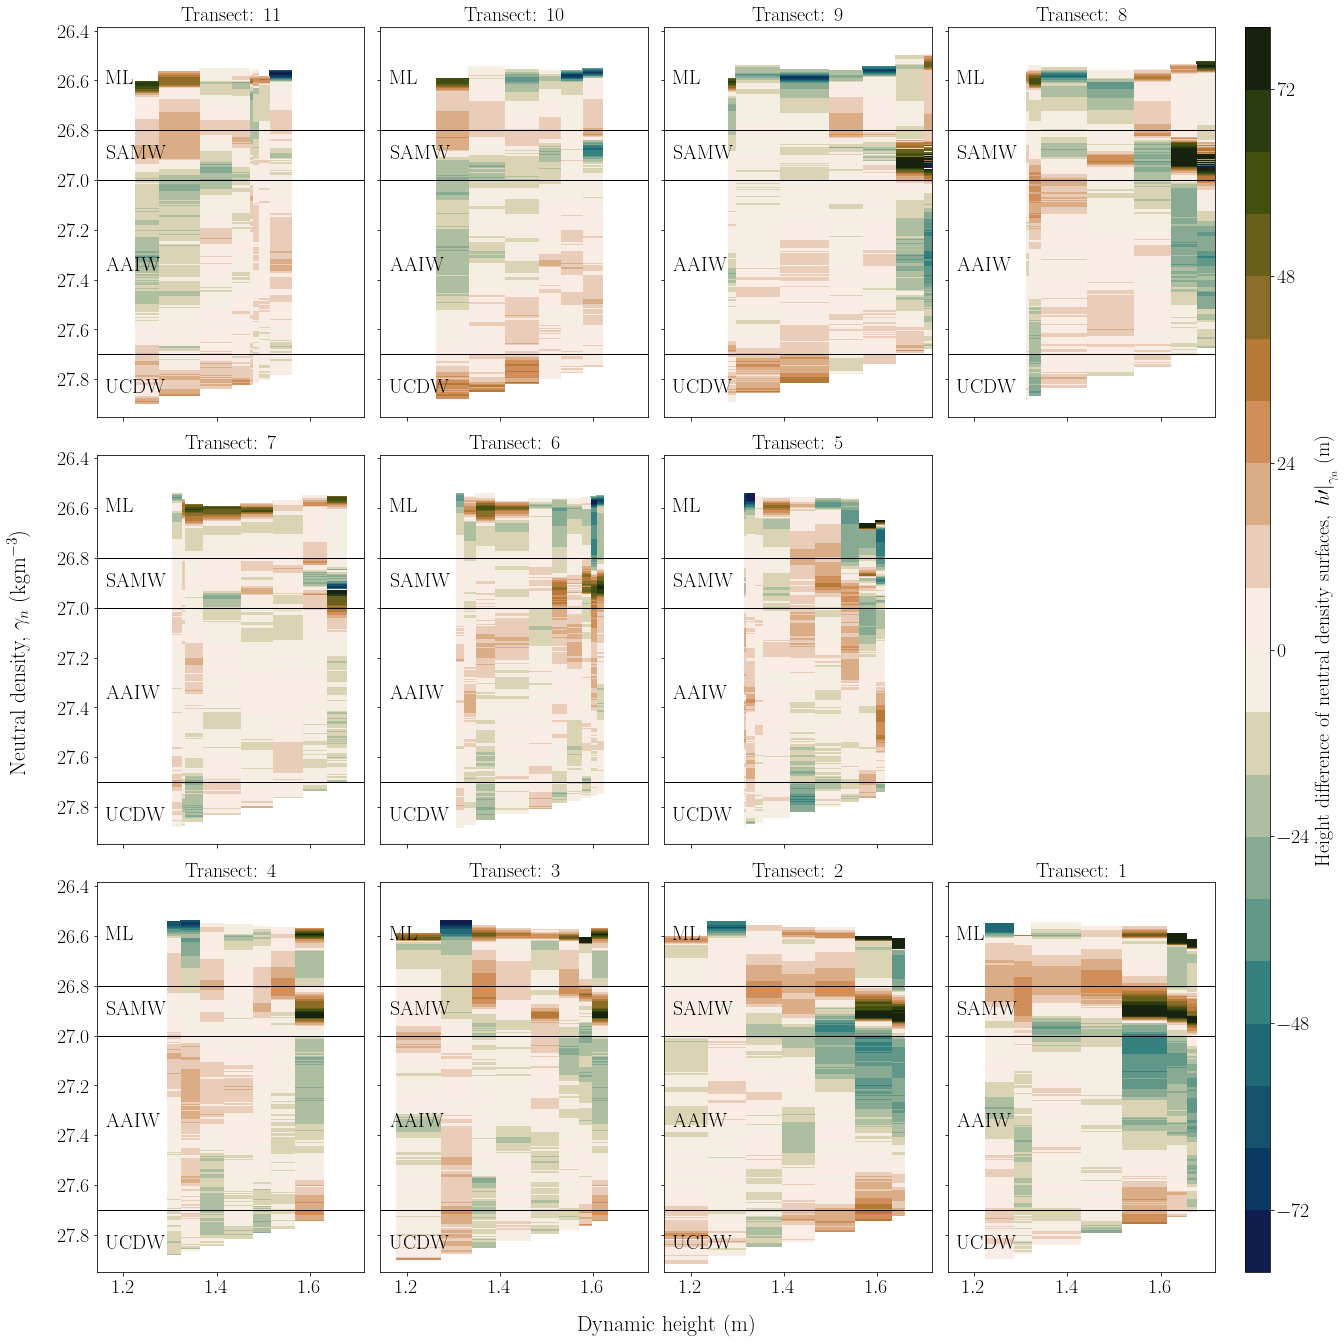

In [17]:
cmap = cmo.cm.tarn_r
bounds = np.linspace(-80, 80, 21)
# cmap=cmo.cm.deep
# bounds = np.linspace(-1500, 0, 16)

norm = mcolors.BoundaryNorm(bounds, ncolors=cmap.N)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(18, 18), sharex=True, sharey=True, constrained_layout=True)
axes[0,0].invert_yaxis()

for ax, transect in zip(axes.flat, reversed(keys)):
    stations = transects[transect]
    
    pcol = ax.pcolormesh(D[stations], gni, h_prime_gn[stations].T, norm=norm, cmap=cmap)
#     pcol = ax.pcolormesh(D[stations], gni, h_mid_gn[stations].T, norm=norm, cmap=cmap)

    for wm in watermass:
        if wm is not 'UCDW':
            ax.axhline(watermass[wm][1], linewidth=1, color='k')
        ax.text(np.nanmin(D[2:]) + .02, np.sum(watermass[wm])/2 + .03, wm, va='bottom', fontsize=fs_small)

    ax.set_title('Transect: %s' % transect, fontsize=fs_small)

cbar = fig.colorbar(pcol, ax=axes.ravel().tolist(), aspect=50)
cbar.ax.set_ylabel(r'Height difference of neutral density surfaces, $\left.h\prime\right|_{\gamma_n}$ (m)', 
                   fontsize=fs_small)
fig.delaxes(axes.flat[-5])

# Set common labels
# fig.text(0.48, 1.02, r'Height difference of neutral density surfaces, $\left.h\prime\right|_{\gamma_n}$ (m)', ha='center', va='center', fontsize=fs_large)
fig.text(0.48, -0.02, 'Dynamic height (m)', ha='center', va='center', fontsize=fs_large)
fig.text(-0.02, 0.5, r'Neutral density, $\gamma_n$ (kgm$^{-3}$)', ha='center', va='center', rotation='vertical', fontsize=fs_large)

# if savefig:
#     fignumber = 'A1_'
#     figname = 'height-difference-heaving'
#     extensions = ['.png', '.pdf', '.eps']
#     for extension in extensions:
#         fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', fignumber + figname + extension), transparent=True)

### R-squared for the spice term and heave term

In [18]:
outliers = [1, 2, 9, 10, 11, 12, 27, 35, 45, 46, 47, 75, 76, 77, 78, 101]
ioutliers = np.array([istat for istat, station in enumerate(ctd['station']) if station in outliers])
inotoutliers = np.array([istat for istat, station in enumerate(ctd['station']) if station not in outliers])

(-2.0, 2.0)

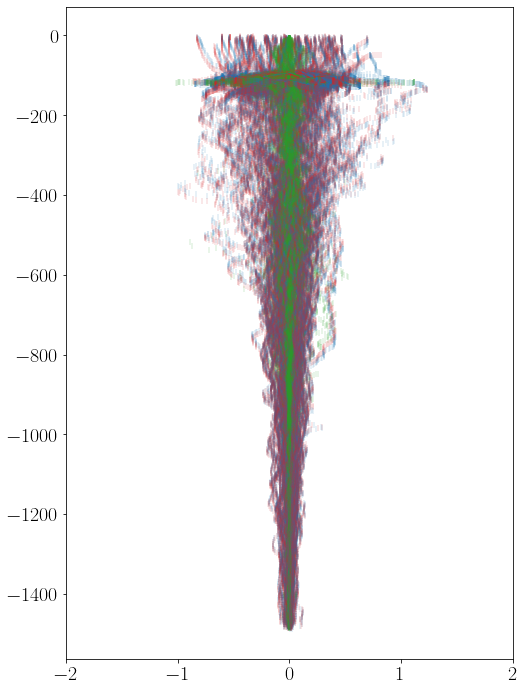

In [25]:
# plt.scatterCT_prime_zm[2:].shape
fig, ax = plt.subplots(figsize=(8,12))
for i in range(zm.shape[1]):
    ax.scatter(CT_prime_zm[inotoutliers, i], zm[inotoutliers, i], marker='|', facecolors='tab:blue', linewidth=0.2)
    ax.scatter(CT_prime_gn[inotoutliers, i], zm[inotoutliers, i], marker='|', facecolors='tab:red', linewidth=0.2)
#     ax.scatter(-(h_prime_gn[inotoutliers, i] * 0.5 * (dCTdz_zm[inotoutliers, i] + dCTdz_gem_zm[inotoutliers, i])), zm[inotoutliers, i], marker='|', facecolors='blue', linewidth=0.2)
    ax.scatter(-(h_prime_gn[inotoutliers, i] * dCTdz_gem_zm[inotoutliers,i]), zm[inotoutliers, i], marker='|', facecolors='tab:green', linewidth=0.2)
ax.set_xlim(-2, 2)

In [20]:
def Rsquared(var_x, var_y, deg=1, mask=None):
    
    mask_x, mask_y = np.ma.masked_invalid(var_x).mask, np.ma.masked_invalid(var_y).mask
    
    if mask is None:
        mask = mask_x | mask_y
    else:
        mask = mask | mask_x | mask_y

    coef = np.polyfit(var_x[~mask], var_y[~mask], deg)
    f = np.poly1d(coef)
    
    # coefficient of determination
    SSres = np.sum((var_y[~mask] - f(var_x)[~mask])**2)
    SStot = np.sum((var_y[~mask] - np.nanmean(var_y[~mask]))**2)
    
    R2 = 1 - (SSres/SStot)
    
    return R2, f

In [21]:
Rsquared(CT_prime_zm[inotoutliers,].flatten(), CT_prime_gn[inotoutliers,].flatten())

(0.882159863752862, poly1d([ 0.88236487, -0.00764892]))

In [22]:
Rsquared(CT_prime_zm[inotoutliers,].flatten(), (-(h_prime_gn[inotoutliers,] * dCTdz_gem_zm[inotoutliers,])).flatten())

(0.0989758230484008, poly1d([ 0.13449172, -0.00080404]))